In [1]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
# Fetch MNIST Dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", as_frame=False)
# mnist contains images so dataframes are not ideal
# we set as_frame=False so that we can get the Numpy arrays

In [3]:
X, y = mnist.data, mnist.target

In [4]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [5]:
X.shape

(70000, 784)

### Notes
- There are 70,000 images and each image has 784 features
- This is because each image has 28 x 28 pixels and each feature is a pixel's intensity. (from 0 [white] to 255 [black])

In [6]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

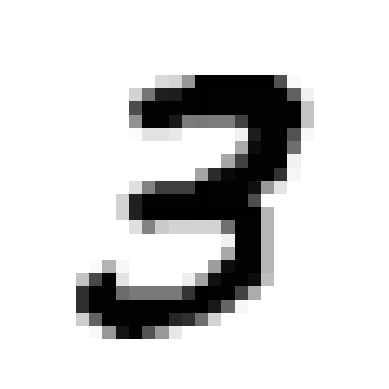

In [7]:
some_digit = X[7]
plot_digit(some_digit)
plt.show()

In [8]:
y[7]

'3'

In [9]:
# Splitting into train and test
# MNIST is automatically split into train and test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a Binary Classifier (5 or Non-5)

In [10]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5') # True if 5, False if not

In [11]:
y_test_5

array([False, False, False, ..., False,  True, False])

In [12]:
# Training a stochastic gradient descent (SGD) calssifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5) # Trains on all the data, but only sees true/false values as the labels (5 or not)

SGDClassifier(random_state=42)

In [13]:
# Now see how it does for some random digits (20)
import numpy as np

rand_idxs = np.random.randint(1, 60000, size=20)
for rand_idx in rand_idxs:
    if sgd_clf.predict([X_train[rand_idx]])[0] == False:
        print(f"The model predicted that this is not a 5.")
    else:
        print(f"The model predicted that this is a 5.")
    print(f"This is actually a {y_train[rand_idx]}")

The model predicted that this is not a 5.
This is actually a 6
The model predicted that this is not a 5.
This is actually a 9
The model predicted that this is not a 5.
This is actually a 7
The model predicted that this is not a 5.
This is actually a 1
The model predicted that this is not a 5.
This is actually a 3
The model predicted that this is not a 5.
This is actually a 6
The model predicted that this is a 5.
This is actually a 5
The model predicted that this is not a 5.
This is actually a 9
The model predicted that this is not a 5.
This is actually a 6
The model predicted that this is not a 5.
This is actually a 1
The model predicted that this is not a 5.
This is actually a 9
The model predicted that this is a 5.
This is actually a 5
The model predicted that this is not a 5.
This is actually a 2
The model predicted that this is not a 5.
This is actually a 2
The model predicted that this is not a 5.
This is actually a 5
The model predicted that this is not a 5.
This is actually a 3


## Measuring Accuracy Using Cross-Validation

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

While 95% accuracy may seem like a good score, it is not necessarily.

In [15]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # check if any items in list are True

False


In [16]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

So we can see that even the dummy classifier achieves over 90% accuracy by always guessing that the given number is NOT a 5. This is because only about 10% of the dataset are 5s. So **accuracy is not always the best performance measure for classification problems**.

## Confusion Matrices

In [17]:
from sklearn.model_selection import cross_val_predict

# cross_val_predict returns the predictions made on each fold (instead of the score)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)

[[53892   687]
 [ 1891  3530]]


Each row in a confusion matrix represents an actual class while each column represents a predicted class. 
To me it looks like:
- 53,892 elements that are not 5s were correcly identified as not 5s.
- 687 elements that are not 5s were incorrectly identified as 5s.
- 1891 elements that are 5s were incorrectly identified as not 5s.
- 3530 elements that are 5s were correctly identified as 5s.

So accuracy here is about (3530 + 53892) / 70000

# Precision and Recall
- **Precision**: The accuracy of the positive predictions. = TP / (TP + FP)
- **Recall (Sensitivity) (True Positive Rate)**: The ratio of positive instances that are correctly detected. = TP / (TP + FN)

In [19]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


- When our classifier claims an image represents a 5, it is correct 83.7% of the time.
- Our classifier only detects 65.1% of 5s.

## F1 Score
- This is the harmonic mean of precision and recall
- Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values.
- The classifier will only get a high F1 score if both recall and precision are high.

**Increasing precision reduces recall**

In [20]:
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))

0.7325171197343847


The way SGD classifier works:
- It computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class, otherwise it assigns it to the negative class.

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

[-4988.52407755]


In [22]:
# We know this digit is a 3, so our classifier is, and the decision score from the sgd classifier is -4900, so with a threshold of 0, it will classify this as negative (not a 5)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


In [23]:
# If we reduce the threshold to say -5000, we will see that the precision is negatively impacted
# We incorrectly detect the false as a positive
threshold = -5000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]


In [24]:
# To determine what threshold to use, use cross_val_predict and return decision scores instead of predictions
y_decision_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
print(y_decision_scores) # This contains the decision scores that SGD classifier finds for each item in X_train
# Those scores greater than a defined threshold will be classified as 5s

[  1200.93051237 -26883.79202424 -33072.03475406 ...  13272.12718981
  -7258.47203373 -16877.50840447]


In [25]:
# With these scores, use the precision_recall_curve function to compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_decision_scores)

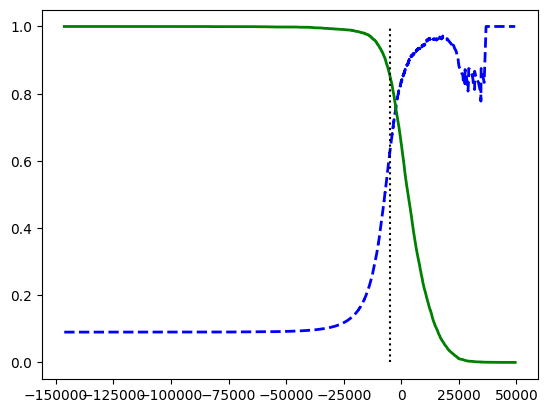

In [26]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.show()

From the graph above, at our current threshold of 5000, we see a recall value of around high 80s and a precision of maybe mid-60s.

The choice of whether to prefer a high precision, or high recall, depends on the specific project. But you can use a graph such as this one to help make that decision.
Examples:
- Spam filter to detect spam emails:
    - It would be preferable to let a few spam filters end up in the inbox, than to have an important email misclassified as spam. Therefore, a high **precision** would be prioritized. We need to make sure that we can be really confident IF the classifier classes this as spam then it is actually spam. 
- Medical diagnostic tool to identify cases of a rare but serious disease:
    - It would be preferable to misdiagnose someone as *having* the disease, as they can always verify with follow up tests, than to have someone who actually has the disease being diagnosed as not having it. So we prefer a high **recall**. 
- For a search engine, you want it display only results relevant to the user's query:
    - We would prefer high **precision** here. It is more important that if a result is returned, it is actually relevant to the user's query than it is to ensure that we capture EVERY possible relevant result.

In [27]:
print(max(precisions))

1.0


In [28]:
# We can search for the lowest threshold that gives you at least 90% precision.
idx_for_90_precision = (precisions >= 0.9).argmax() # the first index where precision >= 90% is True
print(idx_for_90_precision)

57109


In [29]:
print(precisions[idx_for_90_precision])

0.9000345901072293


In [30]:
threshold_for_90_precision = thresholds[idx_for_90_precision]
print(threshold_for_90_precision)

3370.0194991439557


In [31]:
# Now instead of running the classifier's predict() method, you can run:
y_train_pred_90 = (y_decision_scores >= threshold_for_90_precision)
# This returns True for all decision scores that are greater than or equal to the minimum threshold that gives 90% precision

In [32]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## The ROC Curve
- The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers.
- It plots the *true positive rate* (precision) against the *false positive rate*. (FPR) (fall-out).
- The **fall-out** is the ratio of negative instances that are incorrectly classified as positive.
    - This is calculated as 1 - *specificity*. 
- The **specificity** is the true negative rate: the ratio of negative instances that are correctly classified. 
- Therefore, the ROC curve plots **recall** against **1 - specificity**.

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_decision_scores)

In [35]:
# This returns the first index where the threshold value is less than or equal to 
# our previously defined threshold that gives us 90% precision
# thresholds are listed in decreasing order
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
print(idx_for_threshold_at_90)

520


In [36]:
tpr_90 = tpr[idx_for_threshold_at_90]
print(tpr_90)

0.4799852425751706


In [37]:
fpr_90 = fpr[idx_for_threshold_at_90]
print(fpr_90)

0.005295076861063779


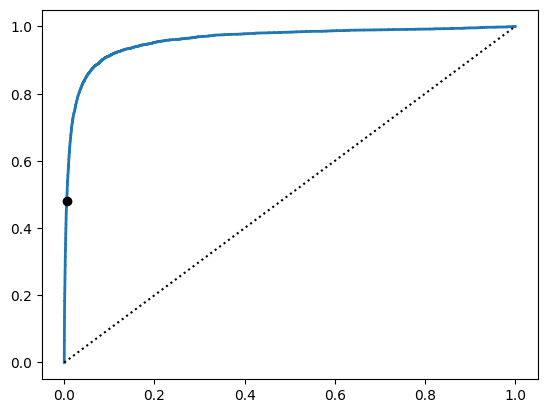

In [38]:
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], "k:", label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.show()

- Once again there is a tradeoff. The higher the recall (TPR), the more false positives the classifier produces. 
- One way to compare classifiers is to measure the area under the curve (AUC).
- A perfect classifier will have a ROC AUC equal to 1
- A purely random classifier will have a ROC AUC equal to 0.5.

In [39]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_decision_scores)

0.9604938554008616

### Deciding between ROC curve and Precision-Recall Curve
- As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives.
- Otherwise use the ROC curve. 

In [40]:
# Creating a Random Forest Classifier whose PR curve and F1 score we can compare to those of the SGD classifier.
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [42]:
# Training the random forest classifier and making it predict probabilities
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

Aim is to generate the auc for the ROC of the DecisionTree Classifier

In [50]:
y_probas_forest[2]

array([0.96, 0.04])

In [52]:
# Taking just the probabilities of the positive class (is a 5)
y_probas_forest_pos = y_probas_forest[:, 1]
y_probas_forest_pos

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

In [53]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_probas_forest_pos)

In [54]:
roc_auc_score(y_train_5, y_probas_forest_pos)

0.9983436731328145

## Multiclass Classification
- *One-versus-all* - You train one binary classifier for each of your possible classes. Then at evaluation time, you get the decision score from each binary classifier and select the classifier whose score is highest.
- *One-versus-one* - Train a binary classifier for each **pair** of digits. This requires *N x (N - 1) / 2* classifiers. 
    - Some algorithms such as support vector machines scale poorly with the size of the training set. OvO is preferred for these because it is faster to train many classifiers on small training sets than it is to train few classifiers on large training sets.

In [55]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [56]:
svm_clf.predict([some_digit])

array(['3'], dtype=object)